In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, concatenate, GlobalAveragePooling2D
)

In [2]:
# Set Parameters
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
EARLY_STOPPING_PATIENCE = 10

In [3]:
# Paths to dataset
TRAIN_DIR = '/content/drive/MyDrive/DatsetBrainTumor/Training'
TEST_DIR = '/content/drive/MyDrive/DatsetBrainTumor/Testing'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2
)

train_generator = data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


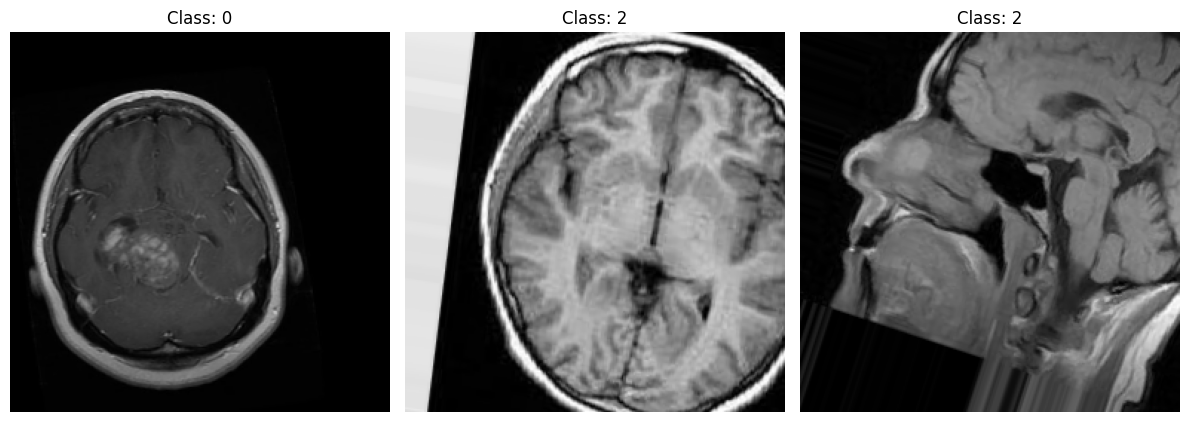

In [6]:
# Ambil batch gambar dari train_generator
sample_batch, sample_labels = next(train_generator)
num_images = 3
plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_batch[i])
    plt.axis('off')
    plt.title(f"Class: {np.argmax(sample_labels[i])}")

plt.tight_layout()
plt.show()


In [7]:
# Ekstraksi Fitur Function
def get_feature_extractor(base_model, input_tensor):
    base = base_model(include_top=False, weights='imagenet', input_tensor=input_tensor)
    output = GlobalAveragePooling2D()(base.output)
    return base.input, output

In [8]:
#Scratched CNN(CNN Custom)
def scratched_cnn(input_tensor):
    # Block 1
    x = Conv2D(112, (5, 5), padding='same')(input_tensor)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pool 2x2

    # Block 2
    x = Conv2D(80, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pool 2x2

    # Block 3
    x = Conv2D(128, (5, 5), padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pool 2x2

    # Block 4
    x = Conv2D(32, (5, 5), padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pool 2x2

    # Flatten and Dense
    x = Flatten()(x)  # Flatten layer menghasilkan 4608 fitur
    x = Dense(768, activation='relu')(x)  # Dense 768 units
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)  # Dropout untuk regularisasi

    return x

In [9]:
input_tensor = Input(shape=(256, 256, 3))

In [10]:
# ========== Stage 1: Feature Extractors ==========
# ResNet50 Ekstraksi Fitur
resnet_input, resnet_output = get_feature_extractor(ResNet50, input_tensor)

# EfficientNetB0 Ekstraksi Fitur
effnet_input, effnet_output = get_feature_extractor(EfficientNetB0, input_tensor)

# Scratched CNN Ekstraksi Fitur
scratched_output = scratched_cnn(input_tensor)

# Kombinasi outputs dari 3 model
combined_output = concatenate([resnet_output, effnet_output, scratched_output])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
# ========== Stage 2: Fully Connected Layers ==========
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(combined_output)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = Dropout(DROPOUT_RATE)(x)
output = Dense(4, activation='softmax')(x)

In [12]:
# Build Model
model = Model(inputs=input_tensor, outputs=output)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1)
]

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 38,840,535 (148.16 MB)

 Trainable params: 38,743,152 (147.79 MB)

 Non-trainable params: 97,383 (380.41 KB)

In [13]:
# Train the Model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 4199s 22s/step - accuracy: 0.7387 - loss: 1.0838 - val_accuracy: 0.3089 - val_loss: 2.3659 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 175s 956ms/step - accuracy: 0.9225 - loss: 0.4799 - val_accuracy: 0.3082 - val_loss: 4.0865 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 200s 939ms/step - accuracy: 0.9393 - loss: 0.4077 - val_accuracy: 0.4371 - val_loss: 3.5285 - learning_rate: 0.0010
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 174s 942ms/step - accuracy: 0.9463 - loss: 0.3778 - val_accuracy: 0.6941 - val_loss: 1.6929 - learning_rate: 0.0010
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 204s 962ms/step - accuracy: 0.9443 - loss: 0.3704 - val_accuracy: 0.9321 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 175s 959ms/step - accuracy: 0.9618 - loss: 0.3146 - val_accuracy: 0.4859 - val_loss: 5.0080 - learning_rate: 0.0010
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 177s 967ms/step - accuracy: 0.9541 -

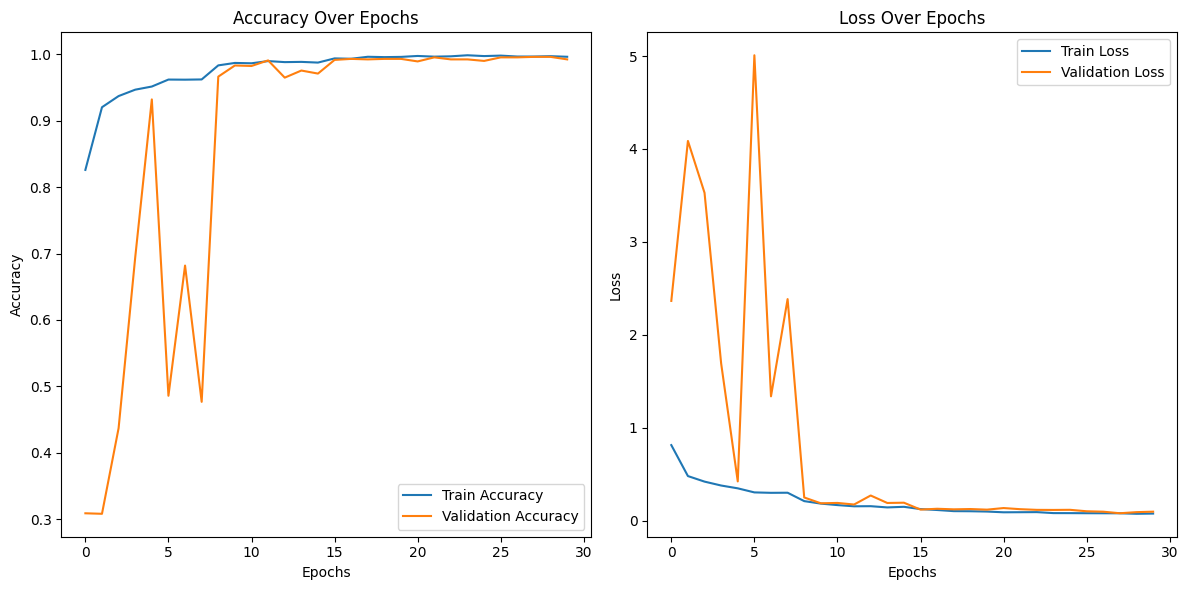

In [14]:
# Plot Training History (Accuracy & Loss)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Evaluate the Model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 636ms/step - accuracy: 0.9960 - loss: 0.0877
Test Loss: 0.0888, Test Accuracy: 0.9962


In [ ]:
# Save the Model
model.save('/content/drive/MyDrive/DatsetBrainTumor/effnet_resnet_ScratchedCNN_classifier_30EPOCH.h5')

In [26]:
# Get predictions
predictions = model.predict(test_generator, verbose=1)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)


41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



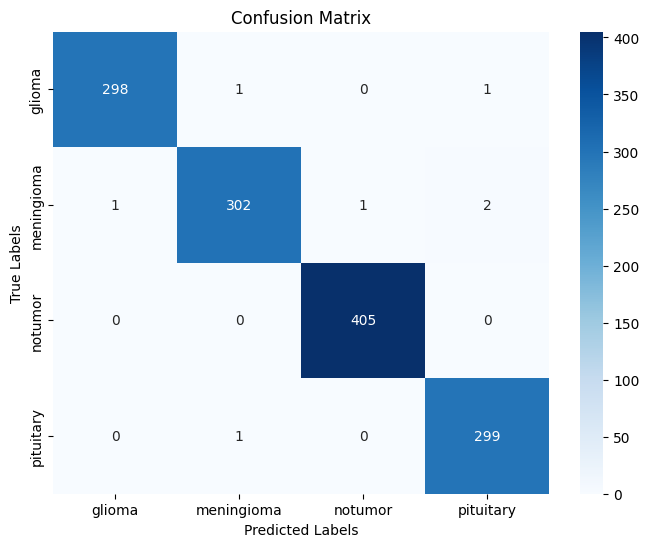

In [27]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
print("Urutan Kelas:")
print(train_generator.class_indices)


Urutan Kelas:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [6]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
MODEL_PATH = '/content/drive/MyDrive/DatsetBrainTumor/effnet_resnet_ScratchedCNN_classifier.h5'
model = load_model(MODEL_PATH)

# Constants for preprocessing
IMAGE_SIZE = (256, 256)
CLASS_NAMES = ['glioma', 'meningioma', 'notumor','pituitary']  # Replace with your actual class names

# Function to preprocess image and predict
def predict(image):
    # Resize and preprocess the image
    img = image.resize(IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class = CLASS_NAMES[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    return f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%"

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Classification",
    description="Upload an image to classify it using the trained ResNet50 + EfficientNet model."
)

# Launch the interface
if __name__ == "__main__":
    interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a41e3d1e1cb79f41a6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
